# Perform CNN using Keras for 12x classes over AWS


In [ ]:
!pip install keras==2.1.5    # Standalized versions between local and cloud.  Bcos weights can't open due to version difference.

In [ ]:
!pip install tensorflow==1.1.0

In [2]:
import tensorflow
tensorflow.__version__

'1.1.0'

In [1]:
import keras
keras.__version__

C:\Users\default.LAPTOP-2CI68M4P\AppData\Local\Continuum\anaconda2\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator

from PIL import ImageFile
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
import itertools
import h5py

%matplotlib inline  


C:\Users\default.LAPTOP-2CI68M4P\AppData\Local\Continuum\anaconda2\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Functions for lots later

In [2]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(16,16), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Image preparation

In [4]:
train_path = 'dataset/training_set'
valid_path = 'dataset/validation_set'
test_path = 'dataset/test_set'

In [5]:
# Define batches
# ImageDataGenerator() is a keras object which generates batches of tensor image data.
# flow_from_directory is where you tell keras where is your images, and their labels.
# flow_from_directory also turns the labels to one-hot-encoded based. chopper=[0,0,1,0...0], clock=[1,0,0...0] 
# In this case we assigned 128x128 only because it yields a better result.
# If using VGG16, we had to change to 224x224, because VGG16 takes this size as inputs.
# If you are working on different classes such as xray images, a different size may be apply to achieve better result.
# This is a trail and error thing.

train_batches = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True).flow_from_directory(train_path, target_size = (128, 128), 
                                                         classes=['clock','massage_chair','microwave','swing','stools','rice_cooker',
                                                                  'frying_pan','chopper', 'pots','scissors','wine_cooler','wine_glass'],
                                                                   batch_size = 20)
valid_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(valid_path, target_size = (128, 128), 
                                                         classes=['clock','massage_chair','microwave','swing','stools','rice_cooker',
                                                                  'frying_pan','chopper', 'pots','scissors','wine_cooler','wine_glass'],
                                                         batch_size = 20)



Found 11498 images belonging to 12 classes.
Found 1898 images belonging to 12 classes.


In [6]:
test_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (128, 128), 
                                                         classes=['clock','massage_chair','microwave','swing','stools','rice_cooker',
                                                                  'frying_pan','chopper', 'pots','scissors','wine_cooler','wine_glass'],
                                                         batch_size = 20)

Found 1898 images belonging to 12 classes.


We put batch size 20. This is the number of images we will be grabbing for iteration.

In [7]:
# Every time we run this, a next sets of 20 images.
imgs, labels = next(train_batches)

In [8]:
# below are 1x batch, here are the lables.
labels

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [9]:
len(imgs)

20

In [10]:
imgs

array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        ...,

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
       

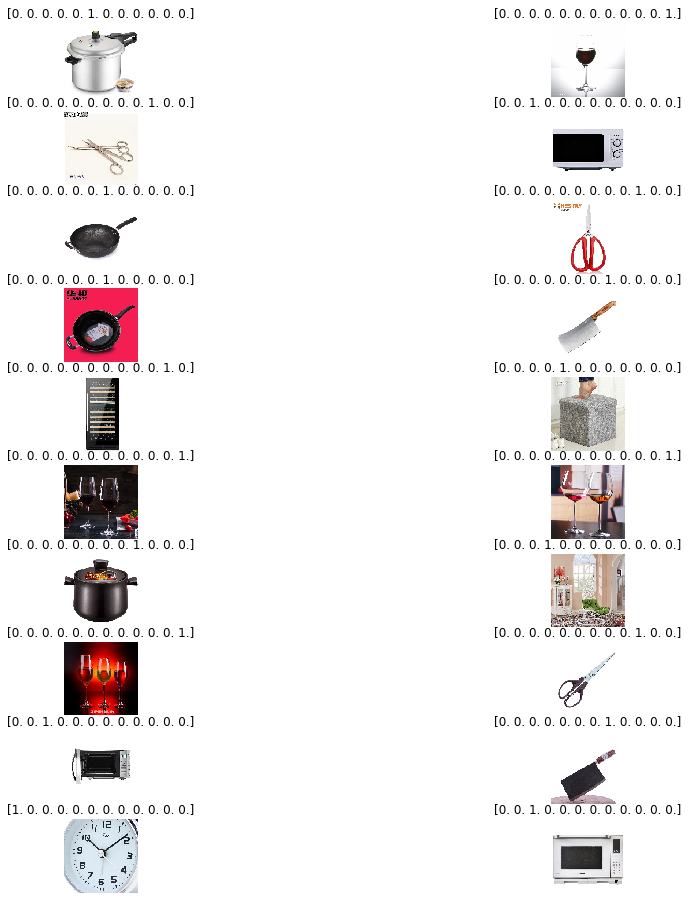

In [11]:
# Batches of 20
plots(imgs, titles = labels)

In [12]:
train_batches.class_indices

{'clock': 0,
 'massage_chair': 1,
 'microwave': 2,
 'swing': 3,
 'stools': 4,
 'rice_cooker': 5,
 'frying_pan': 6,
 'chopper': 7,
 'pots': 8,
 'scissors': 9,
 'wine_cooler': 10,
 'wine_glass': 11}

#### prepare csv to save training logs

In [13]:
# Training with callbacks
from keras import callbacks

filename='logs_7May_12c.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)


# filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# callbacks_list = [csv_log,checkpoint]
callbacks_list = [csv_log]

# Bulid CNN model

In [14]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))  # no of filter 32# can be 3x3 5x5, 7x7 # input shape 128x128 resolution # 3 RGB
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))  # X no. of filters, 3x3 shape of filters, produces feature maps.
classifier.add(MaxPooling2D(pool_size = (2, 2)))      # takes the max value in matrix, but still retained details, reduces size of matrix

classifier.add(Conv2D(64,(3, 3), activation = 'relu'))  
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

classifier.add(Conv2D(64,(3, 3), activation = 'relu'))  
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

classifier.add(Flatten())  # noel... this turns 2d to 1d
classifier.add(Dense(units = 128, activation = 'relu'))  # noel.. this is number of nodes from input.

classifier.add(Dense(units = 12, activation = 'softmax'))  # 12 classes
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
# Viewing model_configuration

classifier.summary()
classifier.get_config()
classifier.layers[0].get_config()
classifier.layers[0].input_shape
classifier.layers[0].output_shape
classifier.layers[0].get_weights()
np.shape(classifier.layers[0].get_weights()[0])
classifier.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
__________

True

In [16]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Training starts NOW!!

In [17]:

classifier.fit_generator(train_batches, steps_per_epoch = 20, 
                         validation_data = valid_batches, validation_steps = 20, 
                         epochs = 500, verbose = 2, callbacks=callbacks_list)

Epoch 1/500
 - 10s - loss: 2.4675 - acc: 0.1100 - val_loss: 2.4757 - val_acc: 0.1100
Epoch 2/500
 - 7s - loss: 2.4371 - acc: 0.1375 - val_loss: 2.4867 - val_acc: 0.1400
Epoch 3/500
 - 7s - loss: 2.3415 - acc: 0.2125 - val_loss: 2.4022 - val_acc: 0.1525
Epoch 4/500
 - 7s - loss: 2.1818 - acc: 0.2400 - val_loss: 2.3183 - val_acc: 0.2325
Epoch 5/500
 - 7s - loss: 2.0885 - acc: 0.2650 - val_loss: 2.0150 - val_acc: 0.3075
Epoch 6/500
 - 7s - loss: 1.8724 - acc: 0.3550 - val_loss: 1.8329 - val_acc: 0.3850
Epoch 7/500
 - 7s - loss: 1.7440 - acc: 0.4250 - val_loss: 2.0886 - val_acc: 0.3550
Epoch 8/500
 - 7s - loss: 1.7327 - acc: 0.4125 - val_loss: 1.7006 - val_acc: 0.4150
Epoch 9/500
 - 7s - loss: 1.7197 - acc: 0.4275 - val_loss: 1.6714 - val_acc: 0.4825
Epoch 10/500
 - 7s - loss: 1.6480 - acc: 0.4625 - val_loss: 1.8220 - val_acc: 0.4275
Epoch 11/500
 - 7s - loss: 1.5839 - acc: 0.4700 - val_loss: 1.7314 - val_acc: 0.4550
Epoch 12/500
 - 7s - loss: 1.4946 - acc: 0.5275 - val_loss: 1.4415 - val_

/home/ec2-user/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 - 7s - loss: 1.3213 - acc: 0.5700 - val_loss: 1.2150 - val_acc: 0.6325
Epoch 21/500
 - 7s - loss: 1.2172 - acc: 0.6025 - val_loss: 1.2398 - val_acc: 0.6300
Epoch 22/500
 - 7s - loss: 1.3463 - acc: 0.5975 - val_loss: 1.1892 - val_acc: 0.6325
Epoch 23/500
 - 7s - loss: 1.3122 - acc: 0.5675 - val_loss: 1.1376 - val_acc: 0.6625
Epoch 24/500
 - 7s - loss: 1.2903 - acc: 0.5850 - val_loss: 1.1898 - val_acc: 0.6475
Epoch 25/500
 - 7s - loss: 1.1943 - acc: 0.6375 - val_loss: 1.1255 - val_acc: 0.6825
Epoch 26/500
 - 7s - loss: 1.1339 - acc: 0.6300 - val_loss: 1.2670 - val_acc: 0.6275
Epoch 27/500
 - 7s - loss: 1.2705 - acc: 0.5850 - val_loss: 1.1454 - val_acc: 0.6775
Epoch 28/500
 - 7s - loss: 1.2023 - acc: 0.6300 - val_loss: 1.1148 - val_acc: 0.6675
Epoch 29/500
 - 7s - loss: 1.0592 - acc: 0.6725 - val_loss: 1.0394 - val_acc: 0.6900
Epoch 30/500
 - 7s - loss: 1.1225 - acc: 0.6400 - val_loss: 1.4145 - val_acc: 0.5950
Epoch 31/500
 - 7s - loss: 1.0473 - acc: 0.6675 - val_loss: 1.0612 - val_acc: 

# Save weights and model to a h5 file 

This save functions saves:
    - The architecture of the model, allowing to re-create the model.
    - The weights of themodel.
    - The training configuraton (loss, optimaizer)
    - The state of the optimizer, allowing to resume training exactly where you left off

In [18]:
classifier.save('cnn_model_weights_12c.h5')

In [19]:
model_json = classifier.to_json()
with open("cnn_model_12c.json","w") as json_file:
    json_file.write(model_json)
classifier.save_weights("cnn_weights_12c.h5")

In [20]:
classifier.save_weights("cnn_weights_12c.h5")

# Prediction

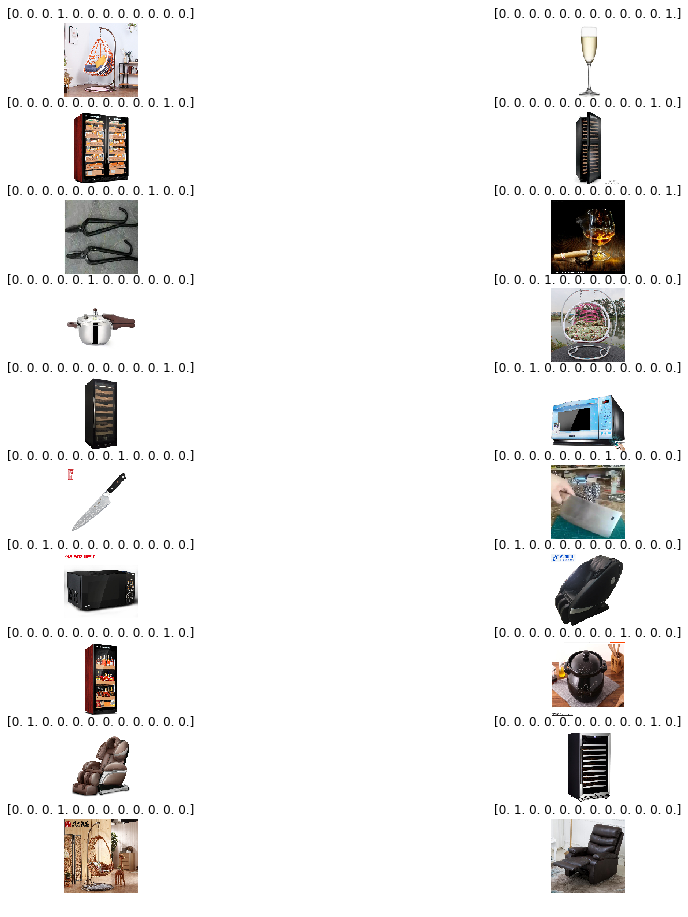

In [21]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [22]:
test_labels_1 = test_labels
test_labels_1

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# dimensions of our images
img_width, img_height = 128, 128

# load the model we saved
model = load_model('cnn_model_weights_12c.h5')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [19]:
test_path = 'dataset/test_set'

test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (128, 128), 
                                                         classes=['clock','massage_chair','microwave','swing','stools','rice_cooker',
                                                                  'frying_pan','chopper', 'pots','scissors','wine_cooler','wine_glass'],
                                                         batch_size = 120)

Found 120 images belonging to 12 classes.


In [20]:
test_imgs, test_labels = next(test_batches)
batch_pred = model.predict_generator(test_batches, steps=1)

#### Confusion Matrix

In [21]:

# Compute confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(batch_pred, axis=1))
np.set_printoptions(precision=2)
cnf_matrix

array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 1,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  9,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 5,  0,  0,  0,  0,  4,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10]], dtype=int64)

Confusion matrix, without normalization
[[10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  1  0  0]
 [ 1  0  0  0  9  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0]
 [ 5  0  0  0  0  4  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10]]


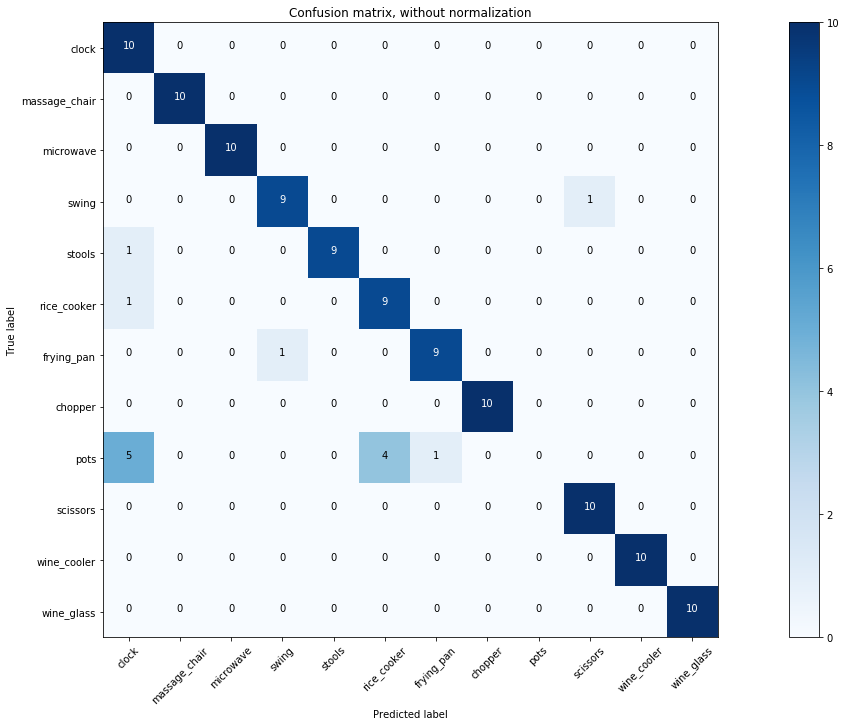

In [22]:
import itertools
# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=['clock','massage_chair','microwave','swing','stools','rice_cooker',
                                     'frying_pan','chopper', 'pots','scissors','wine_cooler','wine_glass'],
                      title='Confusion matrix, without normalization')

#### Classification report

In [25]:
classes=['clock','massage_chair','microwave','swing','stools','rice_cooker', 'frying_pan','chopper', 'pots','scissors','wine_cooler','wine_glass']
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(batch_pred, axis=1),target_names=classes))

               precision    recall  f1-score   support

        clock       0.59      1.00      0.74        10
massage_chair       1.00      1.00      1.00        10
    microwave       1.00      1.00      1.00        10
        swing       0.90      0.90      0.90        10
       stools       1.00      0.90      0.95        10
  rice_cooker       0.69      0.90      0.78        10
   frying_pan       0.90      0.90      0.90        10
      chopper       1.00      1.00      1.00        10
         pots       0.00      0.00      0.00        10
     scissors       0.91      1.00      0.95        10
  wine_cooler       1.00      1.00      1.00        10
   wine_glass       1.00      1.00      1.00        10

  avg / total       0.83      0.88      0.85       120



C:\Users\default.LAPTOP-2CI68M4P\AppData\Local\Continuum\anaconda2\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
import pandas as pd
df = pd.read_csv('./logs_7May_12c.csv', keep_default_na=False)
df.head()

,epoch,acc,loss,val_acc,val_loss
0,0,0.1100,2.467515,0.1100,2.475703
1,1,0.1375,2.437143,0.1400,2.486677
2,2,0.2125,2.341460,0.1525,2.402189
3,3,0.2400,2.181760,0.2325,2.318285
4,4,0.2650,2.088536,0.3075,2.015016


Text(0.5,0,'Number of epochs')

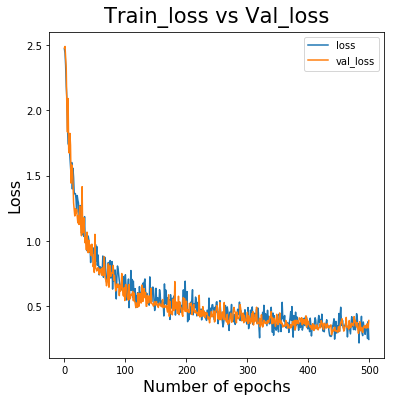

In [27]:
ax = df[['loss','val_loss']].plot(kind='line', figsize=(6,6)) 
ax.set_title('Train_loss vs Val_loss', fontsize=21, y=1.01)
ax.legend(loc=1)                    
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('Number of epochs', fontsize=16)

Text(0.5,0,'Number of epochs')

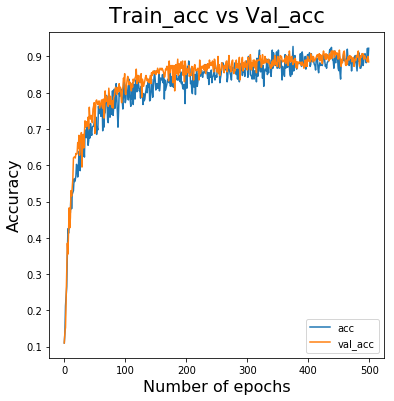

In [28]:
ax = df[['acc','val_acc']].plot(kind='line', figsize=(6,6)) 
ax.set_title('Train_acc vs Val_acc', fontsize=21, y=1.01)
ax.legend(loc=4)                    
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Number of epochs', fontsize=16)